In [11]:
# Some calculation for the LHF coupling and separation across spatial scales.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts/')
import geometry as gm
import warnings; warnings.filterwarnings("ignore")

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def local_variance(field,sigma):
    bar = gm.nan_gaussian_filter(field**2,sigma)
    return bar

def local_covariance(field_a,field_b,sigma):
    bar = gm.nan_gaussian_filter(field_a*field_b,sigma)
    return bar

In [14]:
from scipy.stats import linregress

def density_scatter(x,y,xlabel,ylabel, minititle):
    fig = plt.figure(figsize=(8,5))
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = plt.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
    cb = plt.colorbar(hb, label='counts')
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    plt.title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} (pval={lr_out[3]:.2}) ' + minititle)
    ics = np.array([np.min(x), np.max(x)])
    plt.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    
def density_scatter_ax(ax,x,y,xlabel,ylabel):
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = ax.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
#     cb = ax.colorbar(hb, label='counts')
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    ax.set_title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} ({lr_out[3]:.2})')
    ics = np.array([np.min(x), np.max(x)])
    ax.plot(ics,ics*lr_out[0]+lr_out[1],'r')

In [15]:
# Compute the saturation pressure as in Bolton (1980), as implemented in MetPy 
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.saturation_vapor_pressure.html

B = 17.67 # 1
C = 243.5 # °C
epsilon = 0.622
    
def e_sat(t):
    e_sat0 = 611.2 # Pa
    return e_sat0 * np.exp(B*t/(C+t))

def q_sat(t,p):    
    return epsilon*e_sat(t)/(p-e_sat(t))
    
def dq_sat_dt(t,p):
    return epsilon*e_sat(t)*p*B*C/((p-e_sat(t))**2*(C+t)**2)

def dq2_sat_dt2(t,p):
    return dq_sat_dt(t,p)*(B*C/(C+t)+2*e_sat(t)*B*C/((p-e_sat(t))*(C+t))-2)/(C+t)

In [16]:
import os
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')

In [17]:
# read  data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]

# open dataset with this line of code e.g. 
# xr.open_dataset(wrf_files[files_ls.index('PB.nc')])

# Starting from daily statistics only

In [8]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False); 
sst_day -= 273.15

lon, lat = sst_day.nav_lon, sst_day.nav_lat

ta_day = ds_hourly['T2'].groupby('time_counter.day').mean()            
ta_day = ta_day.where(sea_mask_modified, drop=False); 
ta_day -= 273.15

#### "buoyancy"
buoya_day = sst_day - ta_day

q2_day = ds_hourly['Q2'].groupby('time_counter.day').mean()            
q2_day = q2_day.where(sea_mask_modified, drop=False);    # kg/kg



my_method = False

if not my_method:
    # daily variables
    p0 = 101300.
    RH_day = q2_day/q_sat(ta_day,p0)
elif my_method:
    RH_day = xr.open_dataset('/venus/tesi_ale/data_EU/RH/daily/FEB/RH.nc')
    RH_day = RH_day['rh2_day'].where(sea_mask_modified, drop=False).groupby('time_counter.day').mean()/100. 


In [9]:
if my_method is True:
    # daily variables
    U, V = xr.open_dataset(wrf_files[files_ls.index('U.nc')]), xr.open_dataset(wrf_files[files_ls.index('V.nc')])
    U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
    V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

    U10, V10 = U[:,0,:,:], V[:,0,:,:]    #0.5*(U[:,0,:,:]+U[:,1,:,:]), 0.5*(V[:,0,:,:]+V[:,1,:,:])
    U10, V10 = 0.5*(U10[:,:,0:-1]+U10[:,:,1:]) , 0.5*(V10[:,0:-1,:]+V10[:,1:,:])

    U10, V10 = U10.where(sea_mask_modified, drop=False).values, V10.where(sea_mask_modified, drop=False).values
    ws_10 = (U10**2+V10**2)**0.5


    ## daily mean of wind speed
    ws10_day = np.zeros((29,)+ws_10.shape[1:])
    i = np.arange(29).astype(int)
    for j in i:
        ws10_day[j] = np.nanmean(ws_10[j*8:(j+1)*8], axis=0)

    del ws_10

if my_method is not True:
    U, V = xr.open_dataset(wrf_files[files_ls.index('U.nc')]), xr.open_dataset(wrf_files[files_ls.index('V.nc')])
    U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()
    V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()
    
    U10, V10 = U[:,0,:,:], V[:,0,:,:]    
    U10, V10 = 0.5*(U10[:,:,0:-1]+U10[:,:,1:]) , 0.5*(V10[:,0:-1,:]+V10[:,1:,:])
    U10, V10 = U10.where(sea_mask_modified, drop=False).values, V10.where(sea_mask_modified, drop=False).values
    ws10_day = (U10**2+V10**2)**0.5

In [18]:
# hfx WRF
hfx_wrf = ds_hourly['HFX'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
hfx_wrf = hfx_wrf.where(sea_mask_modified, drop=False)
hfx_wrf = hfx_wrf.groupby('time_counter.day').mean().values

# HIGH-PASS Covariances with SST

In [11]:
scales = np.arange(50, 500, 50)
scales_km = list(2*scales)
scales_km = [str(i)+' km' for i in scales_km]
dictio = {}

for i in range(scales.shape[0]):
    print(i)
    sst_prime     = np.zeros_like(sst_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_sst     = np.zeros_like(sst_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_sst = np.zeros_like(hfx_wrf)
    
    for t in range(0,sst_day.shape[0]):
        sst_sm = gm.nan_gaussian_filter(sst_day[t],scales[i])
        X_prime = sst_day[t] - sst_sm
        sst_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_sst[t] = local_variance(sst_prime[t], scales[i])
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],scales[i])
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_hfx[t] = local_variance(hfx_wrf_prime[t], scales[i])
        
        covar_hfx_sst[t] = local_covariance(hfx_wrf_prime[t], sst_prime[t], scales[i])
        
    dictio[str(scales_km[i])] = covar_hfx_sst/(np.sqrt(var_sst*var_hfx))

0
1
2
3
4
5
6
7
8


In [40]:
type((dictio.get(scales_km[0])))

numpy.ndarray

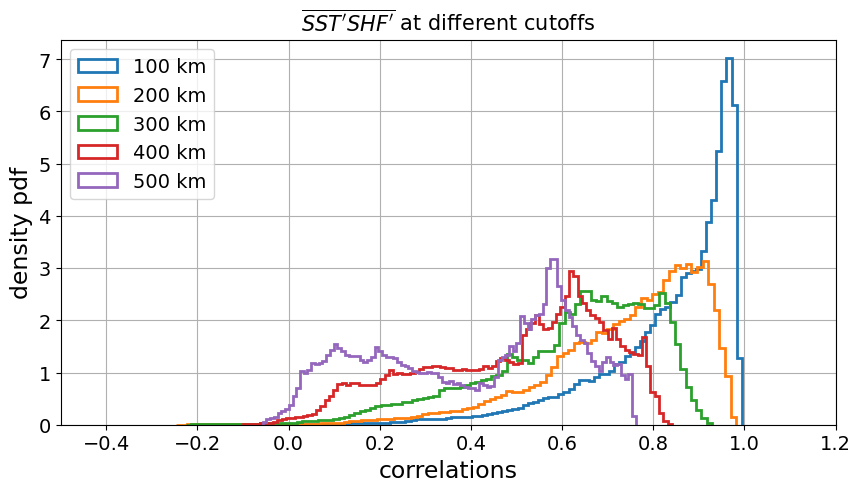

In [13]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))
# fig.suptitle(r"Band-pass   $\overline{SST'LHF'}$  vs  $\overline{U'LHF'}$ vs  $\overline{q'LHF'}$  comparison", fontsize=15)


def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
        if num > 4:
            break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-0.5,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{SST'SHF'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio, labels=scales_km, title=tit, axlabs = [xlab,ylab])
ax.grid()       



# HIGH-PASS Correlations with wind speed

In [14]:
scales = np.arange(25, 300, 25) #np.arange(50, 500, 50)
scales_km = list(2*scales)
scales_km = [str(i)+' km' for i in scales_km]
dictio_wind = {}

for i in range(scales.shape[0]):
    print(i)
    U_prime     = np.zeros_like(ws10_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_U     = np.zeros_like(ws10_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_U = np.zeros_like(hfx_wrf)
    
    for t in range(0,ws10_day.shape[0]):
        U_sm = gm.nan_gaussian_filter(ws10_day[t],scales[i])
        X_prime = ws10_day[t] - U_sm
        U_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_U[t] = local_variance(U_prime[t], scales[i])
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],scales[i])
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_hfx[t] = local_variance(hfx_wrf_prime[t], scales[i])
        
        covar_hfx_U[t] = local_covariance(hfx_wrf_prime[t], U_prime[t], scales[i])
        
    dictio_wind[str(scales_km[i])] = covar_hfx_U/(np.sqrt(var_U*var_hfx))

0
1
2
3
4
5
6
7
8
9
10


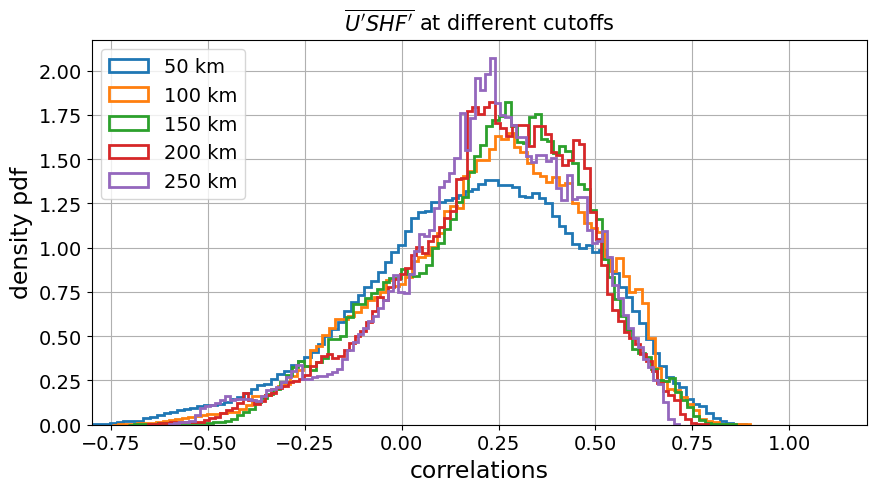

In [16]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
        if num > 4:
            break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-0.8,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{U'SHF'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_wind, labels=scales_km, title=tit, axlabs = [xlab,ylab])
ax.grid()       



# HIGH_PASS Correlations with T


In [17]:
scales = np.arange(20, 200, 20)
scales_km = list(2*scales)
scales_km = [str(i)+' km' for i in scales_km]
dictio_ta = {}

for i in range(scales.shape[0]):
    print(i)
    ta_prime     = np.zeros_like(ta_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_ta     = np.zeros_like(ta_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_ta = np.zeros_like(hfx_wrf)
    
    for t in range(0,ta_day.shape[0]):
        ta_sm = gm.nan_gaussian_filter(ta_day[t],scales[i])
        X_prime = ta_day[t] - ta_sm
        ta_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_ta[t] = local_variance(ta_prime[t], scales[i])
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],scales[i])
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,0)
        var_hfx[t] = local_variance(hfx_wrf_prime[t], scales[i])
        
        covar_hfx_ta[t] = local_covariance(hfx_wrf_prime[t], ta_prime[t], scales[i])
        
    dictio_ta[str(scales_km[i])] = covar_hfx_ta/(np.sqrt(var_ta*var_hfx))

0
1
2
3
4
5
6
7
8


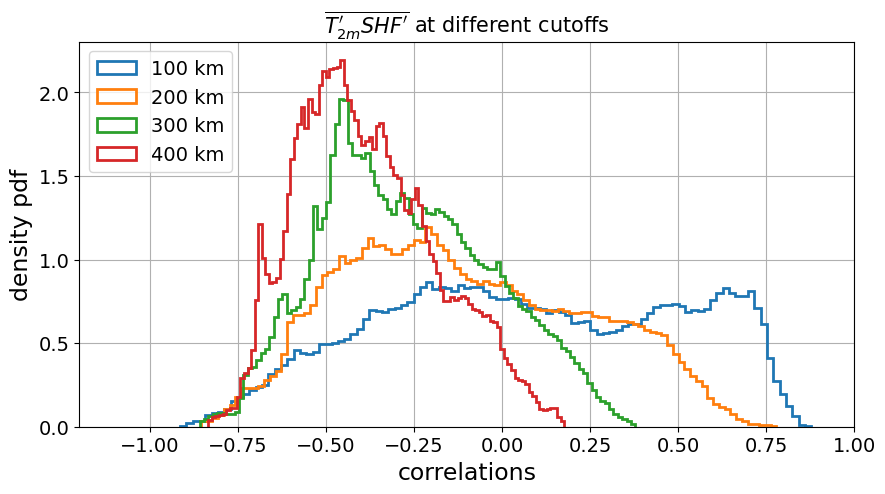

In [20]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
        if num > 3:
            break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-1.2,1)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{T_{2m}'SHF'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_ta, labels=scales_km, title=tit, axlabs = [xlab,ylab])
ax.grid()       



At small scales SHF is forcing the atmosphere, namely $T_{2m}$, thus correlations are more positive than negative on average; whereas at large scales, $T_{2m}$ is following SST and it is thus hindering SHF release

# BAND-PASS correlations with SST

In [19]:
sigma = 150
sigma_sub = np.arange(0, sigma, 30)

#########
# sigma_sub = [30, 60]; sigma_sub = np.array(sigma_sub)
#########

scales_km_bp = list(2*sigma_sub)
scales_km_bp = [str(i)+' km' for i in scales_km_bp]
dictio_sst_bp = {}
# dictio_varSST_bp = {}
# dictio_varHFX_bp = {}

for i in range(sigma_sub.shape[0]):
    print(i)
    sst_prime     = np.zeros_like(sst_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_sst     = np.zeros_like(sst_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_sst_bp = np.zeros_like(hfx_wrf)
    
    for t in range(0,sst_day.shape[0]):
        sst_sm = gm.nan_gaussian_filter(sst_day[t],sigma)
        X_prime = sst_day[t] - sst_sm
        sst_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_sst[t] = local_variance(sst_prime[t], sigma)
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],sigma)
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_hfx[t] = local_variance(hfx_wrf_prime[t], sigma)
        
        
        covar_hfx_sst_bp[t] = local_covariance(hfx_wrf_prime[t], sst_prime[t], sigma)
    
#     dictio_varSST_bp[str(scales_km_bp[i])] = var_sst
#     dictio_varHFX_bp[str(scales_km_bp[i])] = var_hfx
    dictio_sst_bp[str(scales_km_bp[i])] = covar_hfx_sst_bp/(np.sqrt(var_sst*var_hfx))

0
1


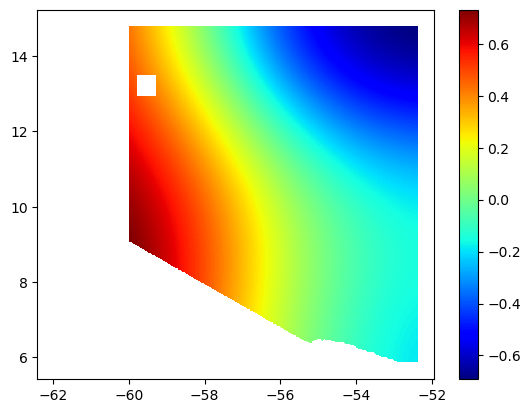

In [27]:
plt.pcolormesh(lon, lat, dictio_sst_bp.get('60 km')[15], cmap='jet') #, vmin=-5, vmax=5)
plt.colorbar()

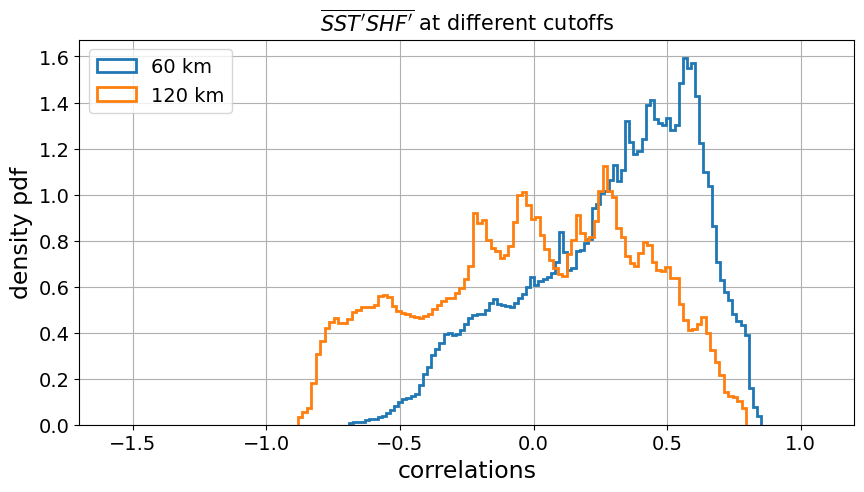

In [20]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    for num, key in enumerate(dictionary):
        lnwd = 2

        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-1.7,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{SST'SHF'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_sst_bp, labels=scales_km_bp, title=tit, axlabs = [xlab,ylab])
ax.grid()       



At large scales, so between 270km and 300km in the bandpass, we should observe that the atmosphere is close to be forcing the ocean, so the signal in $\overline{U'SST'}$ should agree with that in $\overline{SST'SHF'}$

In [ ]:
sigma = 150
sigma_sub = np.arange(0, sigma, 30)

#########
# sigma_sub = [30, 60]; sigma_sub = np.array(sigma_sub)
#########

scales_km_bp = list(2*sigma_sub)
scales_km_bp = [str(i)+' km' for i in scales_km_bp]
dictio_sstU_bp = {}
# dictio_varSST_bp = {}
# dictio_varU_bp = {}

for i in range(sigma_sub.shape[0]):
    print(i)
    sst_prime     = np.zeros_like(sst_day)
    U_prime = np.zeros_like(U)
    
    var_sst     = np.zeros_like(sst_day)
    var_U = np.zeros_like(U)
    covar_U_sst_bp = np.zeros_like(U)
    
    for t in range(0,sst_day.shape[0]):
        sst_sm = gm.nan_gaussian_filter(sst_day[t],sigma)
        X_prime = sst_day[t] - sst_sm
        sst_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_sst[t] = local_variance(sst_prime[t], sigma)
        
        U_sm = gm.nan_gaussian_filter(ws10_day[t],sigma)
        X_prime = ws10_day[t] - U_sm
        U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_U[t] = local_variance(U_prime[t], sigma)
        
        
        covar_U_sst_bp[t] = local_covariance(U_prime[t], sst_prime[t], sigma)
    
#     dictio_varSST_bp[str(scales_km_bp[i])] = var_sst
#     dictio_varU_bp[str(scales_km_bp[i])] = var_U
    dictio_sstU_bp[str(scales_km_bp[i])] = covar_U_sst_bp/(np.sqrt(var_sst*var_U))

In [ ]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
#         if num > 4:
#             break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-1,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{U'SST'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_sstU_bp, labels=scales_km_bp, title=tit, axlabs = [xlab,ylab])
ax.grid()       



# BAND-PASS wind speed

In [25]:
sigma = 150
sigma_sub = np.arange(0, sigma, 30)
scales_km_bp = list(2*sigma_sub)
scales_km_bp = [str(i)+' km' for i in scales_km_bp]
dictio_U_bp = {}

for i in range(sigma_sub.shape[0]):
    print(i)
    U_prime     = np.zeros_like(ws10_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_U     = np.zeros_like(ws10_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_U_bp = np.zeros_like(hfx_wrf)
    
    for t in range(0,ws10_day.shape[0]):
        U_sm = gm.nan_gaussian_filter(ws10_day[t],sigma)
        X_prime = ws10_day[t] - U_sm
        U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_U[t] = local_variance(U_prime[t], sigma)
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],sigma)
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_hfx[t] = local_variance(hfx_wrf_prime[t], sigma)
        
        covar_hfx_U_bp[t] = local_covariance(hfx_wrf_prime[t], U_prime[t], sigma)
        
    dictio_U_bp[str(scales_km_bp[i])] = covar_hfx_U_bp/(np.sqrt(var_U*var_hfx))

0
1
2
3
4
5
6
7


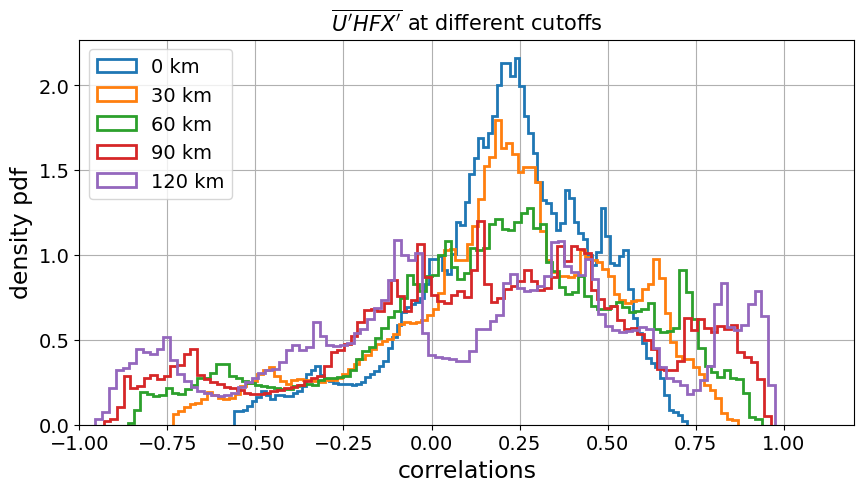

In [34]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
#         if num > 4:
#             break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper left')
        ax.set_xlim(-1,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{U'HFX'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_U_bp, labels=scales_km_bp, title=tit, axlabs = [xlab,ylab])
ax.grid()       



# BAND-PASS correlations with Ta

In [30]:
sigma = 150
sigma_sub = np.arange(0, sigma, 15)
scales_km_bp = list(2*sigma_sub)
scales_km_bp = [str(i)+' km' for i in scales_km_bp]
dictio_ta_bp = {}

for i in range(sigma_sub.shape[0]):
    print(i)
    ta_prime     = np.zeros_like(ta_day)
    hfx_wrf_prime = np.zeros_like(hfx_wrf)
    
    var_ta     = np.zeros_like(ta_day)
    var_hfx = np.zeros_like(hfx_wrf)
    covar_hfx_ta_bp = np.zeros_like(hfx_wrf)
    
    for t in range(0,ta_day.shape[0]):
        ta_sm = gm.nan_gaussian_filter(ta_day[t],sigma)
        X_prime = ta_day[t] - ta_sm
        ta_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_ta[t] = local_variance(ta_prime[t], sigma)
        
        hfx_sm = gm.nan_gaussian_filter(hfx_wrf[t],sigma)
        X_prime = hfx_wrf[t] - hfx_sm
        hfx_wrf_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub[i])
        var_hfx[t] = local_variance(hfx_wrf_prime[t], sigma)
        
        covar_hfx_ta_bp[t] = local_covariance(hfx_wrf_prime[t], ta_prime[t], sigma)
        
    dictio_ta_bp[str(scales_km_bp[i])] = covar_hfx_ta_bp/(np.sqrt(var_ta*var_hfx))

0
1
2
3
4
5
6
7
8
9


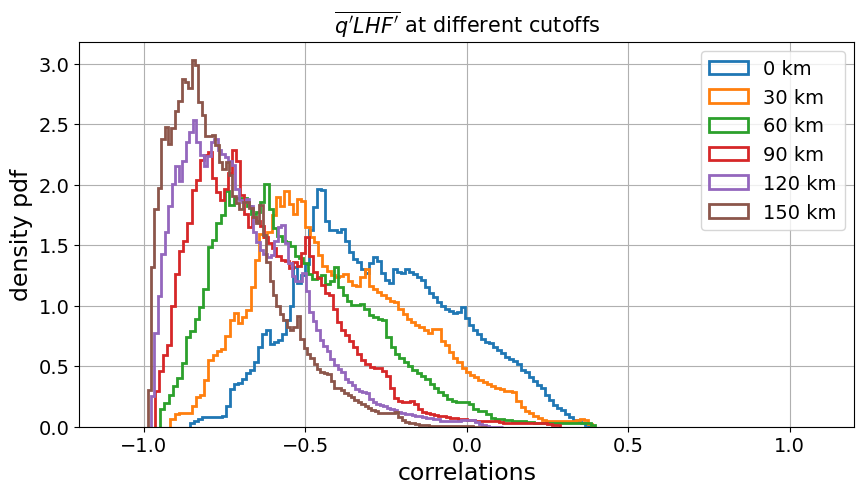

In [35]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

def histogram_local(ax, bins, dictionary, labels, title, axlabs):
    keys = list(dictionary.keys())
    for num, key in enumerate(dictionary):
        if num > 5:
            break
        lnwd = 2
        
        ax.hist((dictionary.get(key)).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labels, fontsize=14, loc='upper right')
        ax.set_xlim(-1.2,1.2)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel(axlabs[0], fontsize=17); ax.set_ylabel(axlabs[1], fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
xlab, ylab = 'correlations', 'density pdf'
tit = r"$\overline{T_{2m}'LHF'}$ at different cutoffs"
histogram_local(ax = ax, bins=100, dictionary=dictio_ta_bp, labels=scales_km_bp, title=tit, axlabs = [xlab,ylab])
ax.grid()       



# Disregard from here on

In [10]:
# compute smooth fields and anomalies daily data
sst_bar = np.zeros(sst_day.shape); ta_bar = np.zeros(ta_day.shape); Dt_bar = np.zeros(Dt_day.shape) 
RH_bar = np.zeros(RH_day.shape); qa_bar = np.zeros(q2_day.shape); U_bar = np.zeros(ws10_day.shape) 
sst_prime = np.zeros(sst_day.shape); ta_prime = np.zeros(ta_day.shape); Dt_prime = np.zeros(Dt_day.shape) 
RH_prime = np.zeros(RH_day.shape); qa_prime = np.zeros(q2_day.shape); U_prime = np.zeros(ws10_day.shape) 

sigma = 'inf'
sigma_sub = 0
sigma_inff = False

if (isinstance(sigma, str)) and (sigma=='inf'):
    sigma_inff = True

for t in range(0,sst_day.shape[0]):
    sst_bar[t] = gm.nan_gaussian_filter(sst_day[t],sigma)
    X_prime = sst_day[t] - sst_bar[t]
    sst_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    ta_bar[t] = gm.nan_gaussian_filter(ta_day[t],sigma)
    X_prime = ta_day[t] - ta_bar[t]
    ta_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    Dt_bar[t] = gm.nan_gaussian_filter(Dt_day[t],sigma)
    X_prime = Dt_day[t] - Dt_bar[t]
    Dt_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    qa_bar[t] = gm.nan_gaussian_filter(q2_day[t],sigma)
    X_prime = q2_day[t] - qa_bar[t]
    qa_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    RH_bar[t] = gm.nan_gaussian_filter(RH_day[t],sigma)
    X_prime = RH_day[t] - RH_bar[t]
    RH_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    U_bar[t] = gm.nan_gaussian_filter(ws10_day[t],sigma)
    X_prime = ws10_day[t] - U_bar[t]
    U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)

# Plotting for data viz

In [11]:
# Now compute the LHF with the bulk formula and separate its large and small scale contributions.

p0 = 101300
rho_a = 1.2 # kg/m3
# Lv = 2.5e6-ta_ff*(2.5-2.2)*1e4 # J/kg
Lv = 2.5e6 # J/kg
Ch = 1.3e-3 # representative value of the exchange coefficient (it has a weak dependence on the wind speed)
beta = rho_a*Lv*Ch

# LHF WRF
lhf_wrf = ds_hourly['LH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
lhf_wrf = lhf_wrf.where(sea_mask_modified, drop=False)
lhf_wrf = lhf_wrf.groupby('time_counter.day').mean().values

# direct bulk formula
lhf_dir = beta*ws10_day*(q_sat(sst_day.values,p0)-q2_day.values)   # Ch has that value when using g/kg 

# If we use the formulation with the RH explicitly.
lhf_rh = beta*ws10_day*(q_sat(sst_day.values,p0)-(RH_day.values)*q_sat(ta_day.values,p0))

In [12]:
lhf_rh_bar, lhf_dir_bar = np.zeros(lhf_rh.shape), np.zeros(lhf_dir.shape);
lhf_rh_prime, lhf_dir_prime = np.zeros(lhf_rh.shape), np.zeros(lhf_dir.shape)
for t in range(0,sst_day.shape[0]):
    lhf_rh_bar[t] = gm.nan_gaussian_filter(lhf_rh[t],sigma)
    X_prime = lhf_rh[t] - lhf_rh_bar[t]
    lhf_rh_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    lhf_dir_bar[t] = gm.nan_gaussian_filter(lhf_dir[t],sigma)
    X_prime = lhf_dir[t] - lhf_dir_bar[t]
    lhf_dir_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)

In [22]:
# Compute the lambdas.
dir_bulk = True
if not dir_bulk:
    lambda_U = beta*(q_sat(sst_bar,p0)-RH_bar*q_sat(ta_bar,p0))
    lambda_sst = beta*U_bar*dq_sat_dt(sst_bar,p0)
    lambda_ta = -beta*U_bar*RH_bar*dq_sat_dt(ta_bar,p0)
    lambda_RH = -beta*U_bar*q_sat(ta_bar,p0)
    lambda_q = -beta*U_bar*0
else:
    lambda_U = beta*(q_sat(sst_bar,p0)-RH_bar*q_sat(ta_bar,p0))
    lambda_sst = beta*U_bar*dq_sat_dt(sst_bar,p0)
    lambda_ta = -beta*U_bar*RH_bar*dq_sat_dt(ta_bar,p0)*0.
    lambda_RH = -beta*U_bar*q_sat(ta_bar,p0)*0.
    lambda_q = -beta*U_bar

In [23]:
def variance(x):
    n = np.sum(~np.isnan(x))
    x_mean = np.nanmean(x)
    var = np.nansum((x-x_mean)**2.)/(n-1)
    return var

def covariance(x1,x2):
    n = np.sum(~np.isnan(x1))
    x1_mean = np.nanmean(x1)
    x2_mean = np.nanmean(x2)
    cov = np.nansum((x1-x1_mean)*(x2-x2_mean))/(n-1)
    return cov

In [24]:
# Compute the total local variance of the LHF.

lhf_prime = lhf_dir_prime if dir_bulk else lhf_rh_prime
var_lhf = np.zeros(lhf_prime.shape)

if not sigma_inff:
    for t in range(0,lhf_prime.shape[0]):
        var_lhf[t] = local_variance(lhf_prime[t],sigma)
elif sigma_inff:
    for t in range(0,lhf_prime.shape[0]):
        var_lhf[t] = variance(lhf_prime[t])

In [25]:
# Compute variance
dims = var_lhf.shape
var_U = np.zeros(dims); var_ta = np.zeros(dims); var_sst =  np.zeros(dims); var_RH = np.zeros(dims)
covar_U_ta = np.zeros(dims); covar_U_sst = np.zeros(dims); covar_U_RH =  np.zeros(dims)
covar_ta_sst = np.zeros(dims); covar_ta_RH = np.zeros(dims); covar_RH_sst =  np.zeros(dims)
covar_lhf_sst = np.zeros(dims); var_qa = np.zeros(dims); covar_U_q = np.zeros(dims); covar_q_sst = np.zeros(dims)
covar_U_lhf = np.zeros(dims)

if not sigma_inff:
    for t in range(0,sst_day.shape[0]):
        # non sst terms
        var_qa[t] = local_variance(qa_prime[t],sigma)
        var_U[t] = local_variance(U_prime[t],sigma)
        var_ta[t] = local_variance(ta_prime[t],sigma)
        var_RH[t] = local_variance(RH_prime[t],sigma)
        covar_U_ta[t] = local_covariance(U_prime[t],ta_prime[t],sigma)
        covar_U_RH[t] = local_covariance(U_prime[t],RH_prime[t],sigma)
        covar_ta_RH[t] = local_covariance(RH_prime[t],ta_prime[t],sigma)
        covar_U_q[t] = local_covariance(U_prime[t],qa_prime[t],sigma)
        covar_U_lhf[t] = local_covariance(U_prime[t],lhf_prime[t],sigma)

        # sst terms
        var_sst[t] = local_variance(sst_prime[t],sigma)
        covar_lhf_sst[t] = local_covariance(lhf_prime[t],sst_prime[t],sigma)
        covar_ta_sst[t] = local_covariance(sst_prime[t],ta_prime[t],sigma)
        covar_U_sst[t] = local_covariance(U_prime[t],sst_prime[t],sigma)
        covar_RH_sst[t] = local_covariance(sst_prime[t],RH_prime[t],sigma)
        covar_q_sst[t] = local_covariance(sst_prime[t],qa_prime[t],sigma)

elif sigma_inff:
        # non sst terms
        var_qa[t] = variance(qa_prime[t])
        var_U[t] = variance(U_prime[t])
        var_ta[t] = variance(ta_prime[t])
        var_RH[t] = variance(RH_prime[t])
        covar_U_ta[t] = covariance(U_prime[t],ta_prime[t])
        covar_U_RH[t] = covariance(U_prime[t],RH_prime[t])
        covar_ta_RH[t] = covariance(RH_prime[t],ta_prime[t])
        covar_U_q[t] = covariance(U_prime[t],qa_prime[t])
        covar_U_lhf[t] = covariance(U_prime[t],lhf_prime[t])

        # sst terms
        var_sst[t] = variance(sst_prime[t])
        covar_lhf_sst[t] = covariance(lhf_prime[t],sst_prime[t])
        covar_ta_sst[t] = covariance(sst_prime[t],ta_prime[t])
        covar_U_sst[t] = covariance(U_prime[t],sst_prime[t])
        covar_RH_sst[t] = covariance(sst_prime[t],RH_prime[t])
        covar_q_sst[t] = covariance(sst_prime[t],qa_prime[t])

if not dir_bulk:
    sst_terms = (lambda_sst**2*var_sst + 
                 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
    
    non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                     2*lambda_U*lambda_ta*covar_U_ta + 2*lambda_U*lambda_RH*covar_U_RH + 2*lambda_ta*lambda_RH*covar_ta_RH)
    
    var_lhf_sum = sst_terms + non_sst_terms
else:
    sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
    non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
    var_lhf_sum = sst_terms + non_sst_terms
    

In [26]:
sigma_inff

True

In [27]:
import pandas as pd
time = pd.date_range(start='2/1/2020', end='2/29/2020')

list_vars = [lambda_sst, lambda_U, lambda_ta, lambda_RH, lambda_q, 
             var_lhf, var_sst, var_U, var_ta, var_RH, 
             covar_U_sst, covar_ta_sst, covar_RH_sst, covar_U_ta,
             covar_U_RH, covar_ta_RH, covar_lhf_sst, covar_U_q, covar_q_sst, var_qa, 
             sst_prime, ta_prime, qa_prime, U_prime, RH_prime, lhf_prime, covar_U_lhf]


name_vars = ['lambda_sst', 'lambda_U', 'lambda_ta', 'lambda_RH', 'lambda_q',
             'var_lhf', 'var_sst', 'var_U', 'var_ta', 'var_RH', 
             'covar_U_sst', 'covar_ta_sst', 'covar_RH_sst', 'covar_U_ta',
             'covar_U_RH', 'covar_ta_RH', 'covar_lhf_sst', 'covar_U_q', 'covar_q_sst', 'var_qa', 
             'sst_prime', 'ta_prime', 'qa_prime', 'U_prime', 'RH_prime', 'lhf_prime', 'covar_U_lhf']


if len(list_vars) == len(name_vars):
    print('var lists ok')
    ds_out = xr.Dataset()#coords={'day':time})

    for i in range(len(name_vars)):
        ds_out[name_vars[i]] = xr.DataArray(list_vars[i], name=name_vars[i],\
                                            dims=['day', 'lat', 'lon'])
else:
    print('something missing in either of the two var lists')

var lists ok


In [28]:
print(dir_bulk)
print(len(list_vars))
sigma, sigma_sub

True
27


('inf', 0)

In [29]:
ds_out.attrs['description'] = 'ALE sigma inf, daily means, DIR formulation'

In [30]:
fout = '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_sigma-inf_lhfDIR_dailyMeans_all.nc'
ds_out.to_netcdf(fout)
ds_out.close()
del ds_out

In [41]:
# version 2
list_vars = [lambda_sst, lambda_U, lambda_ta, lambda_RH, \
             var_lhf, var_sst, var_U, var_ta, var_RH, \
             covar_U_sst, covar_ta_sst, covar_RH_sst, covar_U_ta, covar_U_RH, covar_ta_RH]
name_vars = ['lambda_sst', 'lambda_U', 'lambda_ta', 'lambda_RH', \
             'var_lhf', 'var_sst', 'var_U', 'var_ta', 'var_RH', \
             'covar_U_sst', 'covar_ta_sst', 'covar_RH_sst', 'covar_U_ta', 'covar_U_RH', 'covar_ta_RH']
time = pd.date_range(start='2/1/2020', end='2/29/2020')
list_coords = [time]
name_coords = ['time']

In [42]:
ds_out = cnv.np2ds(list_vars, name_vars, list_coords, name_coords)
ds_out

<xarray.Dataset>
Dimensions:       (time: 29)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-01 2020-02-02 ... 2020-02-29
Data variables: (12/15)
    lambda_sst    (time) float32 32.53 33.5 29.68 34.27 ... 28.49 32.54 35.31
    lambda_U      (time) float32 21.65 22.95 22.88 21.41 ... 23.79 23.08 22.92
    lambda_ta     (time) float32 -23.27 -23.35 -20.73 ... -19.41 -22.49 -24.46
    lambda_RH     (time) float32 -487.3 -507.5 -453.3 ... -431.4 -492.9 -539.3
    var_lhf       (time) float64 975.3 637.9 477.5 511.8 ... 390.5 720.3 587.5
    var_sst       (time) float64 0.2208 0.2078 0.1869 ... 0.2325 0.2503 0.2402
    ...            ...
    covar_U_sst   (time) float64 0.3832 0.06244 0.2464 ... 0.168 0.1401 0.00994
    covar_ta_sst  (time) float64 0.2587 0.2253 0.1998 ... 0.2245 0.2492 0.22
    covar_RH_sst  (time) float64 -0.003746 -0.008884 ... 0.00545 0.005613
    covar_U_ta    (time) float64 0.5978 0.04174 0.2807 ... 0.04818 -0.05014
    covar_U_RH    (time) float64 -0.009397 -0.005938 ... -0.001728 -0.003934
    covar_ta_RH   (time) float64 -0.006107 -0.01244 ... 0.007589 0.008266

In [43]:
fout = '/venus/matteo/LHF_scaling_sigmainf_1d.nc'
ds_out.to_netcdf(fout)

# If anyone wanted to compute the 3h estimates of LH, and then daily mean

#### SETTING HERE DIMENSIONS OF BAND-PASS FILTERS
###### A SIGMA_SUB = 0 IMPLIES NO FILTERING

In [8]:
sigma = 100;     sigma_sub = 25

In [9]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

sst  = ds_hourly['SST'].where(sea_mask_modified, drop=False)         
sst  = sst  - 273.15;    sst = sst[::3]

lon, lat = sst .nav_lon, sst .nav_lat

ta  = ds_hourly['T2'].where(sea_mask_modified, drop=False)           
ta  = ta  - 273.15;      ta = ta[::3]


In [10]:
q2  = ds_hourly['Q2'].where(sea_mask_modified, drop=False)
q2 = q2[::3]

RH  = xr.open_dataset('/venus/tesi_ale/data_EU/RH/daily/FEB/RH.nc')
RH  = RH['rh2_3h'].where(sea_mask_modified, drop=False)/100.

In [11]:
# hourly variables
U, V = xr.open_dataset(wrf_files[files_ls.index('U.nc')]), xr.open_dataset(wrf_files[files_ls.index('V.nc')])
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

U10, V10 = U[:,0,:,:], V[:,0,:,:]   #0.5*(U[:,0,:,:]+U[:,1,:,:]), 0.5*(V[:,0,:,:]+V[:,1,:,:])
U10, V10 = 0.5*(U10[:,:,0:-1]+U10[:,:,1:]) , 0.5*(V10[:,0:-1,:]+V10[:,1:,:])

U10, V10 = U10.where(sea_mask_modified, drop=False).values, V10.where(sea_mask_modified, drop=False).values
ws_10 = (U10**2+V10**2)**0.5

del U10, V10

In [12]:
# Now compute the LHF with the bulk formula and separate its large and small scale contributions.

p0 = 101300
rho_a = 1.2 # kg/m3
# Lv = 2.5e6-ta_ff*(2.5-2.2)*1e4 # J/kg
Lv = 2.5e6 # J/kg
Ch = 1.3e-3 # representative value of the exchange coefficient (it has a weak dependence on the wind speed)
beta = rho_a*Lv*Ch

# LHF WRF
lhf_wrf = ds_hourly['LH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
lhf_wrf = lhf_wrf.where(sea_mask_modified, drop=False)
lhf_wrf = lhf_wrf.groupby('time_counter.day').mean().values



In [13]:
# direct bulk formula
lhf_dir = beta*ws_10*(q_sat(sst.values,p0)-q2.values)

# If we use the formulation with the RH explicitly.
lhf_rh = beta*ws_10*(q_sat(sst.values,p0)-(RH.values)*q_sat(ta.values,p0))

### compute daily means here

In [14]:
lhf_dir_day = np.zeros((29,)+lhf_dir.shape[1:])
lhf_rh_day = np.zeros((29,)+lhf_rh.shape[1:])

i = np.arange(29).astype(int)
for j in i:
    lhf_dir_day[j] = np.nanmean(lhf_dir[j*8:(j+1)*8], axis=0)
    lhf_rh_day[j] = np.nanmean(lhf_rh[j*8:(j+1)*8], axis=0)

lhf_dir, lhf_rh = lhf_dir_day, lhf_rh_day
del lhf_dir_day, lhf_rh_day

In [15]:
sst = sst.groupby('time_counter.day').mean()
ta  = ta.groupby('time_counter.day').mean()
q2  = q2.groupby('time_counter.day').mean()
RH  = RH.groupby('time_counter.day').mean()
Dt = sst-ta

In [16]:
ws10_day = np.zeros((29,)+ws_10.shape[1:])
i = np.arange(29).astype(int)
for j in i:
    ws10_day[j] = np.nanmean(ws_10[j*8:(j+1)*8], axis=0)

In [17]:
# compute smooth fields and anomalies daily data
sst_bar = np.zeros(sst.shape); ta_bar = np.zeros(ta.shape); Dt_bar = np.zeros(Dt.shape) 
RH_bar = np.zeros(RH.shape); qa_bar = np.zeros(q2.shape); U_bar = np.zeros(ws10_day.shape) 
sst_prime = np.zeros(sst.shape); ta_prime = np.zeros(ta.shape); Dt_prime = np.zeros(Dt.shape) 
RH_prime = np.zeros(RH.shape); qa_prime = np.zeros(q2.shape); U_prime = np.zeros(ws10_day.shape) 

for t in range(0,sst.shape[0]):
    sst_bar[t] = gm.nan_gaussian_filter(sst[t],sigma)
    X_prime = sst[t] - sst_bar[t]
    sst_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    ta_bar[t] = gm.nan_gaussian_filter(ta[t],sigma)
    X_prime = ta[t] - ta_bar[t]
    ta_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    Dt_bar[t] = gm.nan_gaussian_filter(Dt[t],sigma)
    X_prime = Dt[t] - Dt_bar[t]
    Dt_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    qa_bar[t] = gm.nan_gaussian_filter(q2[t],sigma)
    X_prime = q2[t] - qa_bar[t]
    qa_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    RH_bar[t] = gm.nan_gaussian_filter(RH[t],sigma)
    X_prime = RH[t] - RH_bar[t]
    RH_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    U_bar[t] = gm.nan_gaussian_filter(ws10_day[t],sigma)
    X_prime = ws10_day[t] - U_bar[t]
    U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)

In [18]:
lhf_dir_prime, lhf_rh_prime = np.zeros(lhf_rh.shape), np.zeros(lhf_rh.shape)
lhf_dir_bar, lhf_rh_bar = np.zeros(lhf_rh.shape), np.zeros(lhf_rh.shape)

for t in range(0, sst.shape[0]):
    
    lhf_rh_bar[t] = gm.nan_gaussian_filter(lhf_rh[t],sigma)
    X_prime = lhf_rh[t] - lhf_rh_bar[t]
    lhf_rh_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    lhf_dir_bar[t] = gm.nan_gaussian_filter(lhf_dir[t],sigma)
    X_prime = lhf_dir[t] - lhf_dir_bar[t]
    lhf_dir_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    

Text(0.5, 1.0, 'spatial anomaly')

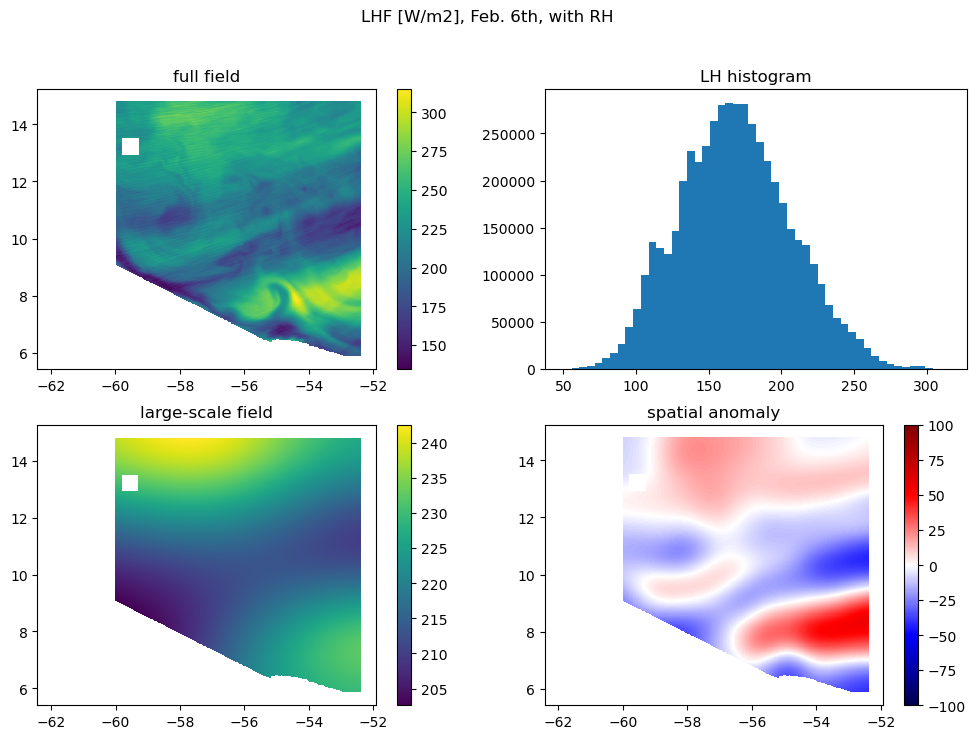

In [19]:
# Separate the small and the large scale LHF.

t = 5
dir_bulk = False
y = lhf_dir if dir_bulk else lhf_rh
y_bar = lhf_dir_bar if dir_bulk else lhf_rh_bar
y_prime = lhf_dir_prime if dir_bulk else lhf_rh_prime

title = f'LHF [W/m2], Feb. {t+1}th';  add = ', direct formulation' if dir_bulk else ', with RH'


fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle(title+add)

pc = axs[0,0].pcolormesh(lon,lat,y[t])  #,shading='nearest')
fig.colorbar(pc,ax=axs[0,0])
axs[0,0].set_title('full field')

axs[0,1].hist(y.flatten(),bins=50)
axs[0,1].set_title('LH histogram')

pc = axs[1,0].pcolormesh(lon,lat,y_bar[t],shading='nearest')
fig.colorbar(pc,ax=axs[1,0])
axs[1,0].set_title('large-scale field')
'''pc = axs[1,0].pcolormesh(lon,lat,sst[t]) #,shading='nearest')
fig.colorbar(pc,ax=axs[1,0])
axs[1,0].set_title('SST full field')'''

pc = axs[1,1].pcolormesh(lon,lat,y_prime[t],cmap='seismic',vmin=-100,vmax=100)  #shading='nearest'
fig.colorbar(pc,ax=axs[1,1])
axs[1,1].set_title('spatial anomaly')

max diff between rh and dir BARS: -3.656234133381799 %
min diff between rh and dir BARS: -10.877716722946946 %

max diff between rh and dir PRIMES: 1.3739788750124902 W/m2
min diff between rh and dir PRIMES: -0.4038080068072496 W/m2


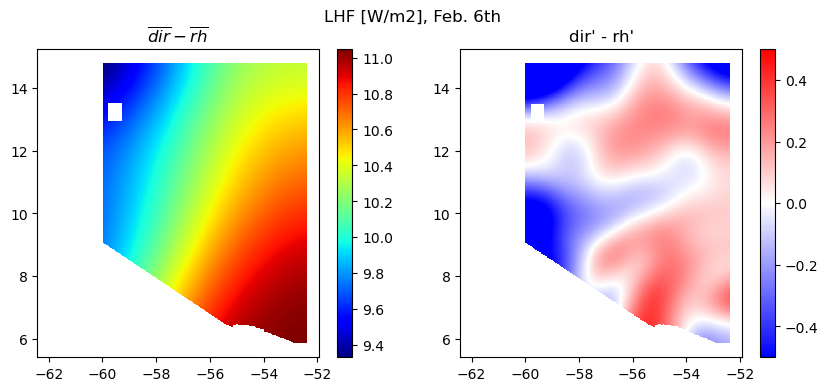

In [20]:
#### differences between dir and rh formulations
fig, axs = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(title)


t=28


pc = axs[0].pcolormesh(lon,lat,lhf_dir_bar[t]-lhf_rh_bar[t], cmap='jet')  #,shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\overline{dir} - \overline{rh}$')


pc = axs[1].pcolormesh(lon,lat,lhf_dir_prime[t]-lhf_rh_prime[t],shading='nearest', vmin=-0.5, vmax=0.5, cmap='bwr')
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('dir\' - rh\'')




print(f'max diff between rh and dir BARS: {np.nanmax((lhf_rh_bar[t]-lhf_dir_bar[t])*100/lhf_dir_bar)} %')
print(f'min diff between rh and dir BARS: {np.nanmin((lhf_rh_bar[t]-lhf_dir_bar[t])*100/lhf_dir_bar)} %\n')

print(f'max diff between rh and dir PRIMES: {np.nanmax((lhf_rh_prime[t]-lhf_dir_prime[t]))} W/m2')
print(f'min diff between rh and dir PRIMES: {np.nanmin((lhf_rh_prime[t]-lhf_dir_prime[t]))} W/m2')

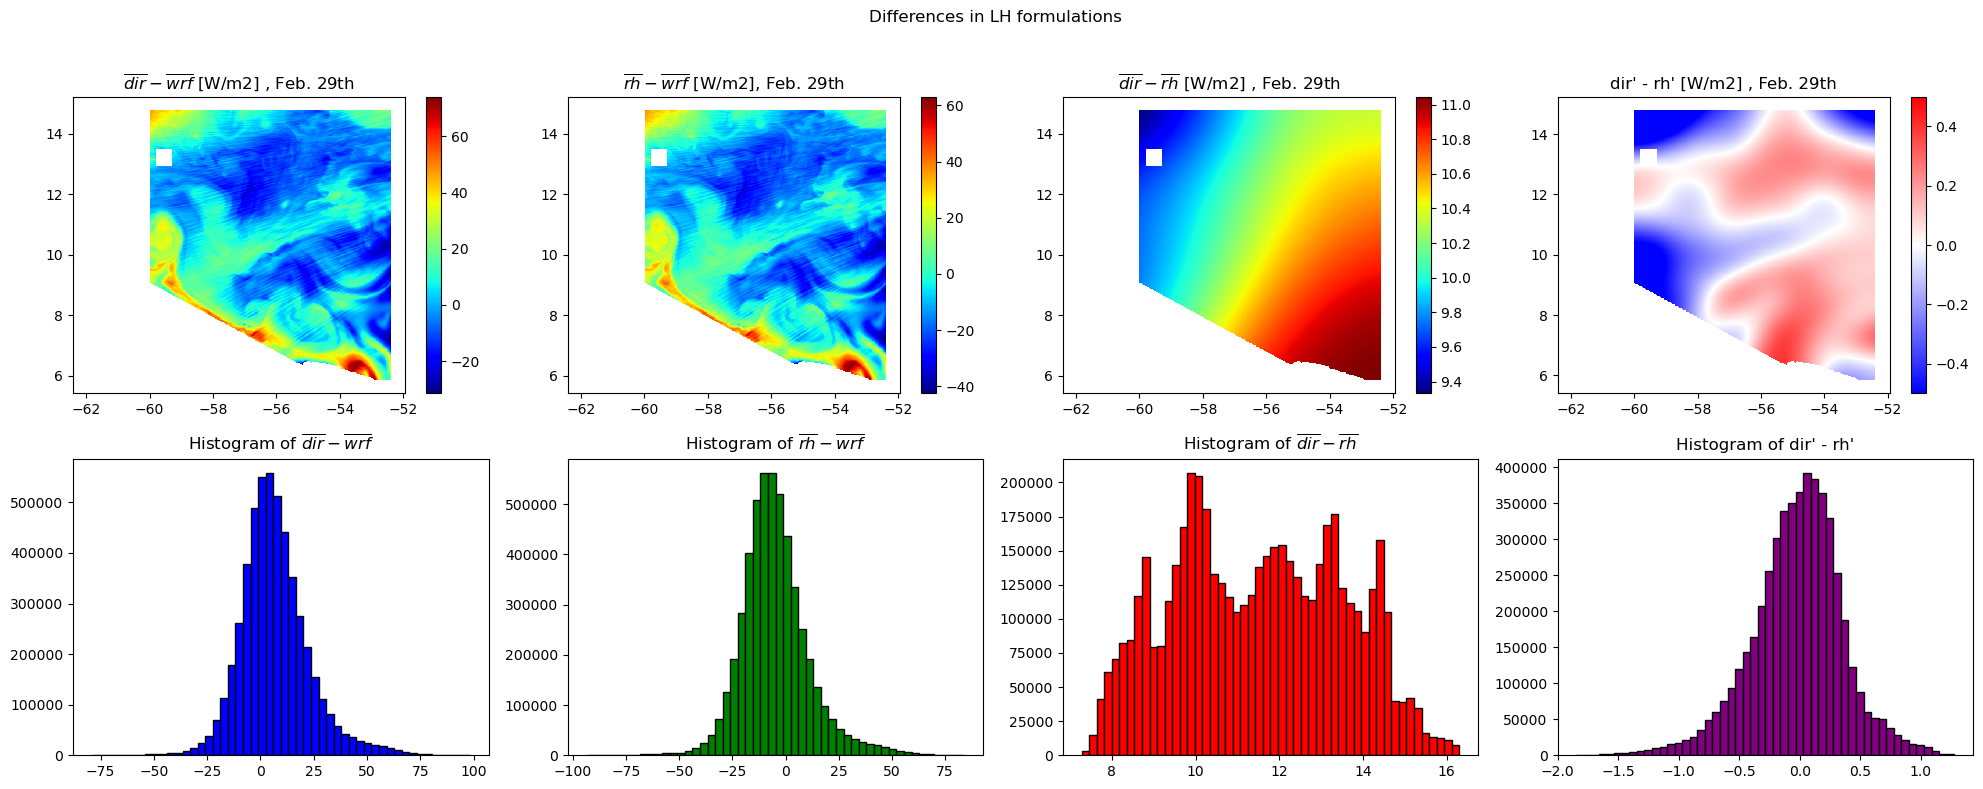

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(20, 8))  # Adjusting the figure size for better visibility
t = 28
title = f'Differences in LH formulations'
fig.suptitle(title)

# Plotting the pcolormesh plots
pc = axs[0, 0].pcolormesh(lon, lat, lhf_dir_bar[t] - lhf_wrf[t], cmap='jet')  # ,shading='nearest')
fig.colorbar(pc, ax=axs[0, 0])
axs[0, 0].set_title('$\overline{dir} - \overline{wrf}$ [W/m2]'+f' , Feb. {t+1}th')

pc = axs[0, 1].pcolormesh(lon, lat, lhf_rh_bar[t] - lhf_wrf[t], cmap='jet')  # ,shading='nearest')
fig.colorbar(pc, ax=axs[0, 1])
axs[0, 1].set_title('$\overline{rh} - \overline{wrf}$'+f' [W/m2], Feb. {t+1}th')

pc = axs[0, 2].pcolormesh(lon, lat, lhf_dir_bar[t] - lhf_rh_bar[t], cmap='jet')  # ,shading='nearest')
fig.colorbar(pc, ax=axs[0, 2])
axs[0, 2].set_title('$\overline{dir} - \overline{rh}$'+f' [W/m2] , Feb. {t+1}th')

pc = axs[0, 3].pcolormesh(lon, lat, lhf_dir_prime[t] - lhf_rh_prime[t], shading='nearest', vmin=-0.5, vmax=0.5, cmap='bwr')
fig.colorbar(pc, ax=axs[0, 3])
axs[0, 3].set_title("dir' - rh' [W/m2]"+f" , Feb. {t+1}th")

# Plotting the histograms
axs[1, 0].hist((lhf_dir_bar - lhf_wrf).flatten(), bins=50, color='blue', edgecolor='black')
axs[1, 0].set_title('Histogram of $\overline{dir} - \overline{wrf}$')

axs[1, 1].hist((lhf_rh_bar - lhf_wrf).flatten(), bins=50, color='green', edgecolor='black')
axs[1, 1].set_title('Histogram of $\overline{rh} - \overline{wrf}$')

axs[1, 2].hist((lhf_dir_bar - lhf_rh_bar).flatten(), bins=50, color='red', edgecolor='black')
axs[1, 2].set_title('Histogram of $\overline{dir} - \overline{rh}$')

axs[1, 3].hist((lhf_dir_prime - lhf_rh_prime).flatten(), bins=50, color='purple', edgecolor='black')
axs[1, 3].set_title("Histogram of dir' - rh'")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/band-pass_LHF-Differences.png')

In [22]:
# Compute the lambdas.
lambda_U = beta*(q_sat(sst_bar,p0)-RH_bar*q_sat(ta_bar,p0))
lambda_sst = beta*U_bar*dq_sat_dt(sst_bar,p0)
lambda_ta = -beta*U_bar*RH_bar*dq_sat_dt(ta_bar,p0)
lambda_RH = -beta*U_bar*q_sat(ta_bar,p0)

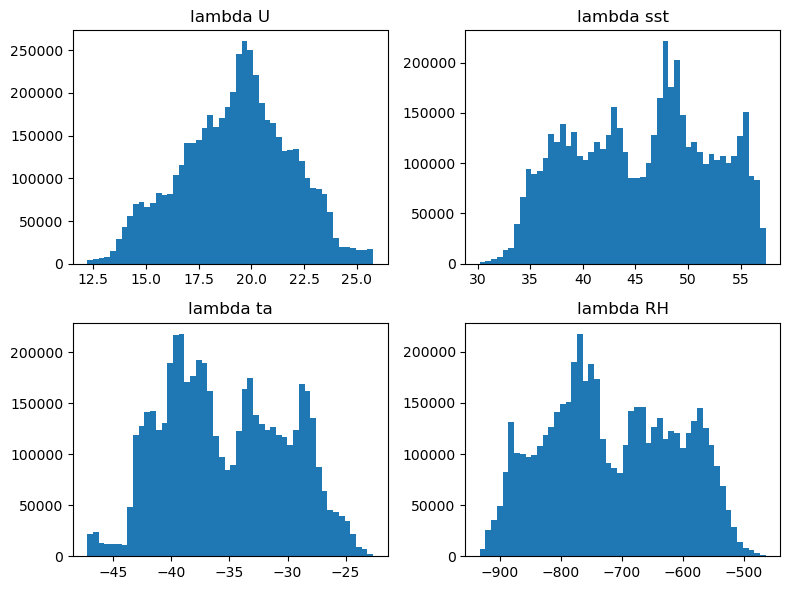

In [23]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
ax = axs.flatten()

ax[0].hist(lambda_U.flatten(), bins=50)
ax[0].set_title('lambda U')

ax[1].hist(lambda_sst.flatten(), bins=50)
ax[1].set_title('lambda sst')

ax[2].hist(lambda_ta.flatten(), bins=50)
ax[2].set_title('lambda ta')

ax[3].hist(lambda_RH.flatten(), bins=50)
ax[3].set_title('lambda RH')

plt.tight_layout()

In [24]:
# Compute variance
def variance(x):
    n = np.sum(~np.isnan(x))
    x_mean = np.nanmean(x)
    var = np.nansum((x-x_mean)**2.)/(n-1)
    return var

def covariance(x1,x2):
    n = np.sum(~np.isnan(x1))
    x1_mean = np.nanmean(x1)
    x2_mean = np.nanmean(x2)
    cov = np.nansum((x1-x1_mean)*(x2-x2_mean))/(n-1)
    return cov

dir_bulk = False
lhf_prime = lhf_dir_prime if dir_bulk else lhf_rh_prime

# Compute the total local variance of the LHF.
var_lhf = np.zeros(lhf_prime.shape)
for t in range(0,lhf_prime.shape[0]):
    var_lhf[t] = local_variance(lhf_prime[t],sigma)


# Compute variance
dims = var_lhf.shape
var_U = np.zeros(dims); var_ta = np.zeros(dims); var_sst =  np.zeros(dims); var_RH = np.zeros(dims)
covar_U_ta = np.zeros(dims); covar_U_sst = np.zeros(dims); covar_U_RH =  np.zeros(dims)
covar_ta_sst = np.zeros(dims); covar_ta_RH = np.zeros(dims); covar_RH_sst =  np.zeros(dims)
covar_lhf_sst = np.zeros(dims)


for t in range(0,sst.shape[0]):
    # non sst terms
    var_U[t] = local_variance(U_prime[t],sigma)
    var_ta[t] = local_variance(ta_prime[t],sigma)
    var_RH[t] = local_variance(RH_prime[t],sigma)
    covar_U_ta[t] = local_covariance(U_prime[t],ta_prime[t],sigma)
    covar_U_RH[t] = local_covariance(U_prime[t],RH_prime[t],sigma)
    covar_ta_RH[t] = local_covariance(RH_prime[t],ta_prime[t],sigma)
    
    # sst terms
    var_sst[t] = local_variance(sst_prime[t],sigma)
    covar_lhf_sst[t] = local_covariance(lhf_prime[t],sst_prime[t],sigma)
    covar_ta_sst[t] = local_covariance(sst_prime[t],ta_prime[t],sigma)
    covar_U_sst[t] = local_covariance(U_prime[t],sst_prime[t],sigma)
    covar_RH_sst[t] = local_covariance(sst_prime[t],RH_prime[t],sigma)

sst_terms = (lambda_sst**2*var_sst + 
             2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                 lambda_U*lambda_ta*covar_U_ta + lambda_U*lambda_RH*covar_U_RH + lambda_ta*lambda_RH*covar_ta_RH)
var_lhf_sum = sst_terms + non_sst_terms


# check whether covariances between each single field 
# can explain the total SST'LHF' covariance

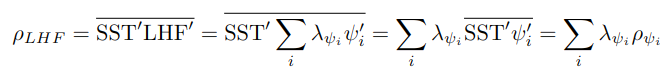

0.0012134514236783467
[-0.1600941254810562, 5.263488351765769]


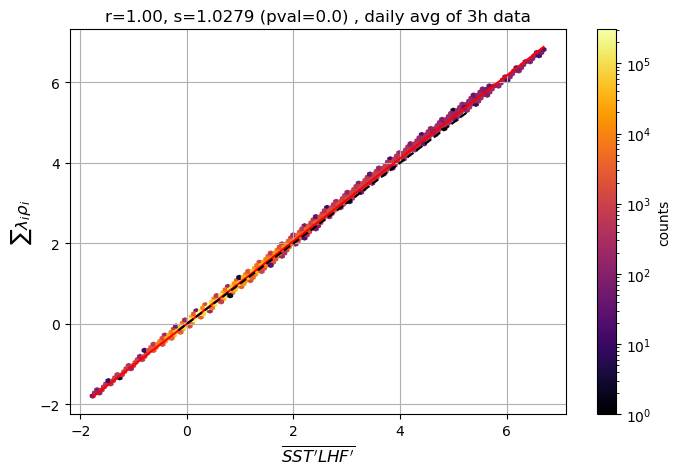

In [25]:
## checking equation above
covar_sum = lambda_U*covar_U_sst + lambda_sst*var_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst

density_scatter(covar_lhf_sst, covar_sum,'$\\overline{SST\' LHF\'}$','$\\sum \\lambda_i \\rho_i$', minititle=', daily avg of 3h data')
ics_rho = [np.nanpercentile(covar_lhf_sst,5),np.nanpercentile(covar_lhf_sst,99.9)]
print(ics_rho)
plt.plot(ics_rho,ics_rho,'k--')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/sigma-inf_scatter-SSTLHF-cov.png')

Text(0, 0.5, 'density pdf')

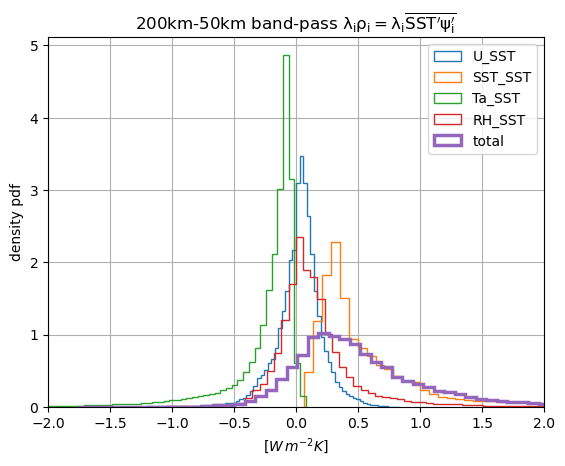

In [28]:
u_sst = lambda_U*covar_U_sst#/covar_lhf_sst
sst_sst = lambda_sst*var_sst#/covar_lhf_sst
ta_sst = lambda_ta*covar_ta_sst#/covar_lhf_sst
rh_sst = lambda_RH*covar_RH_sst#/covar_lhf_sst

bins = 100

plt.hist((u_sst).flatten(),bins=bins,histtype=u'step',density=True)
plt.hist((sst_sst).flatten(),bins=bins,histtype=u'step',density=True)
plt.hist((ta_sst).flatten(),bins=bins,histtype=u'step',density=True)
plt.hist((rh_sst).flatten(),bins=bins,histtype=u'step',density=True)
plt.hist((covar_lhf_sst).flatten(),bins=bins,histtype=u'step',density=True, linewidth=2.5)


plt.legend(['U_SST', 'SST_SST', 'Ta_SST', 'RH_SST', 'total'])

plt.grid(); plt.xlim(-2,2)
plt.title('200km-50km band-pass $\\rm \\lambda_i \\rho_i = \\lambda_i \\overline{SST\'\\psi_i \'}$ ')   #\; / \; \\overline{SST\'LHF\'}$')
plt.xlabel(r'$[W\,m^{-2} K]$');  plt.ylabel('density pdf')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass_lambda-rho_SSTLHF_means-of-3h.png')


# How about the LHF variance?

18.671447600572918
[26.918171379873236, 846.8939325639301]


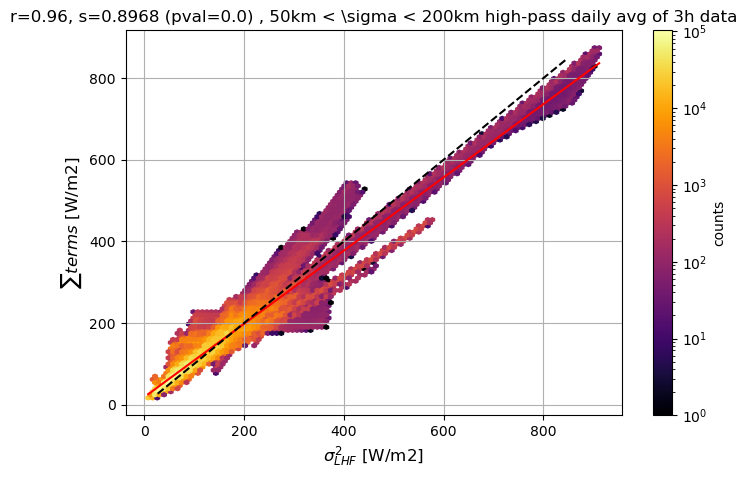

In [33]:
t = 0
density_scatter(var_lhf,var_lhf_sum,r'$\\sigma_{LHF}^2$ [W/m2]','$\\sum terms$ [W/m2]', minititle=', 50km < \\sigma < 200km high-pass daily avg of 3h data')
ics = [np.nanpercentile(var_lhf,5),np.nanpercentile(var_lhf,99.9)]
print(ics)
plt.plot(ics,ics,'k--')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass_scatterVar_means-of-3h.png')

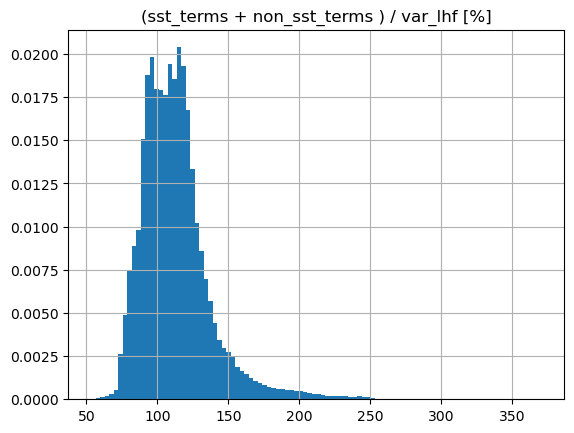

In [30]:
plt.hist(((sst_terms+non_sst_terms)*100./var_lhf).flatten(),bins=100,density=True)
plt.grid();  
plt.title('(sst_terms + non_sst_terms ) / var_lhf [%]')

plt.show()

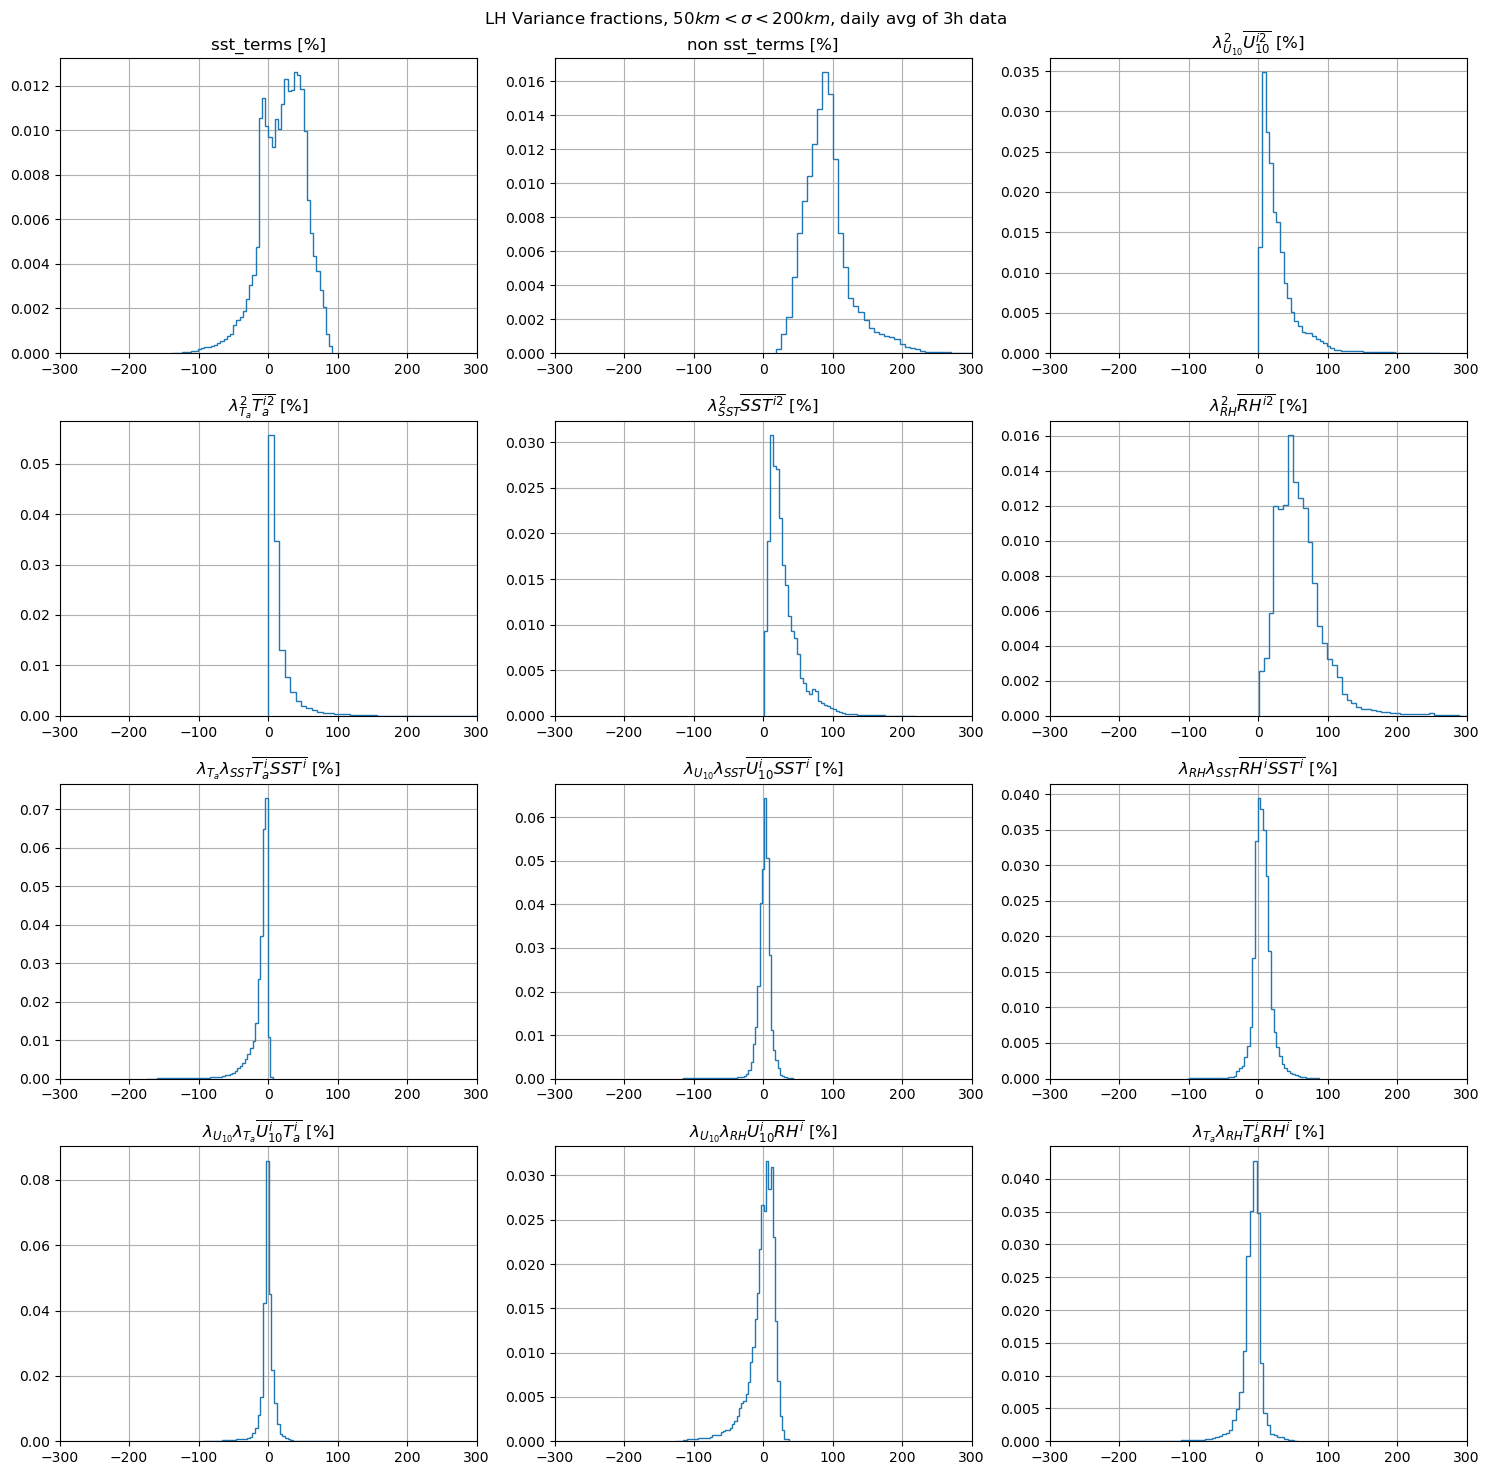

In [31]:
fig, axs = plt.subplots(4,3,figsize=(15,15))
axs = axs.flatten()

fig.suptitle(r'LH Variance fractions, $50km < \sigma < 200km$, daily avg of 3h data')

# dir_bulk = True
# lhf_prime = lhf_dir_prime if dir_bulk else lhf_rh_prime

xperc=300
bins=50

# t = -6

ax=axs[0]
ax.hist((sst_terms*100./var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
# ax.vlines((sst_terms*100./var_lhf)[t], 0, 0.05)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('sst_terms [%]')

ax=axs[1]
ax.hist((non_sst_terms*100./var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('non sst_terms [%]')

ax=axs[2]
ax.hist((lambda_U**2*var_U*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)

ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')

ax=axs[3]
ax.hist((lambda_ta**2*var_ta*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [%]')

ax=axs[4]
ax.hist((lambda_sst**2*var_sst*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')

ax=axs[5]
ax.hist((lambda_RH**2*var_RH*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{RH}^2 \\overline{RH^{i2}}$ [%]')

ax=axs[6]
ax.hist((lambda_ta*lambda_sst*covar_ta_sst*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [%]')

ax=axs[7]
ax.hist((lambda_U*lambda_sst*covar_U_sst*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]')

ax=axs[8]
ax.hist((lambda_RH*lambda_sst*covar_RH_sst*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [%]')

ax=axs[9]
ax.hist((lambda_U*lambda_ta*covar_U_ta*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{T_a} \\overline{U_{10}^{i}T_a^i}$ [%]')

ax=axs[10]
ax.hist((lambda_U*lambda_RH*covar_U_RH*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{RH} \\overline{U_{10}^{i}RH^i}$ [%]')

ax=axs[11]
ax.hist((lambda_ta*lambda_RH*covar_ta_RH*100/var_lhf).flatten(),bins=bins,histtype=u'step',density=True)
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{T_a}\\lambda_{RH} \\overline{T_a^{i}RH^i}$ [%]')

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass_allTerms_means-of-3h.png')

In [53]:
lon.nav_lon[0,:]

<xarray.DataArray 'nav_lon' (x: 573)>
array([-62.417824, -62.399494, -62.38116 , ..., -51.96847 , -51.950138,
       -51.93181 ], dtype=float32)
Coordinates:
    nav_lat  (x) float32 5.416 5.416 5.416 5.416 ... 5.416 5.416 5.416 5.416
    nav_lon  (x) float32 -62.42 -62.4 -62.38 -62.36 ... -51.97 -51.95 -51.93
Dimensions without coordinates: x
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [47]:
### save data
# Coordinates

import pandas as pd
time = pd.date_range(start='2/1/2020', end='2/29/2020')

list_vars = [lambda_sst, lambda_U, lambda_ta, lambda_RH, 
             var_lhf, var_sst, var_U, var_ta, var_RH, 
             covar_U_sst, covar_ta_sst, covar_RH_sst, covar_U_ta,
             covar_U_RH, covar_ta_RH, covar_lhf_sst]

name_vars = ['lambda_sst', 'lambda_U', 'lambda_ta', 'lambda_RH', 
             'var_lhf', 'var_sst', 'var_U', 'var_ta', 'var_RH', 
             'covar_U_sst', 'covar_ta_sst', 'covar_RH_sst', 'covar_U_ta',
             'covar_U_RH', 'covar_ta_RH', 'covar_lhf_sst']

ds_out = xr.Dataset(coords={'day':time})

for i in range(len(name_vars)):
    ds_out[name_vars[i]] = xr.DataArray(list_vars[i], name=name_vars[i],\
                                        dims=['day', 'lat', 'lon'])



# ds_out.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/lambda-covars_band-pass200-50_lhf-rh_means-of-3h.png')

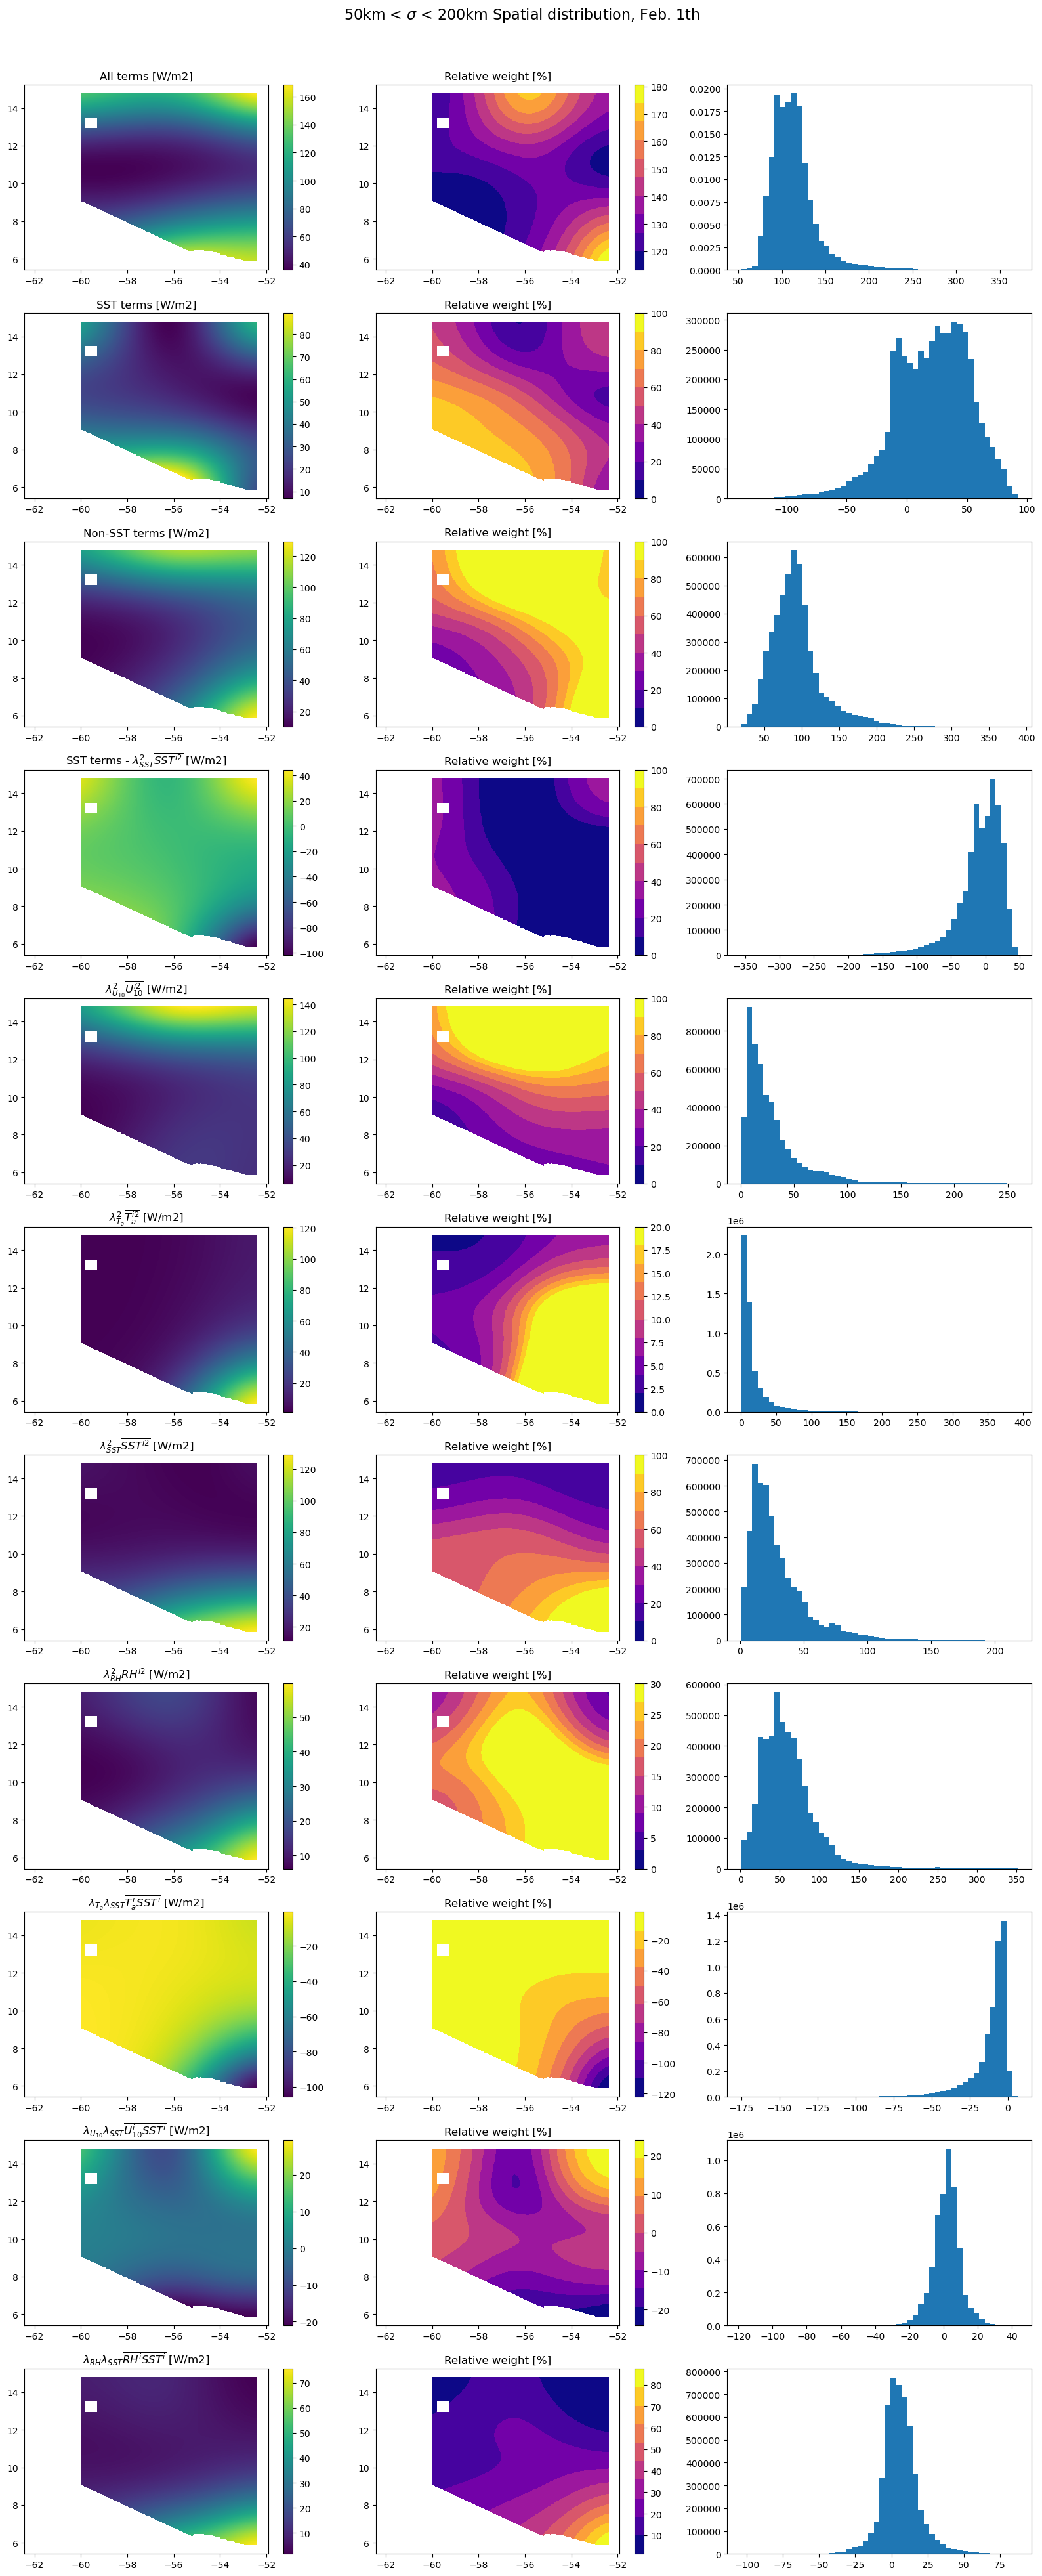

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming the variables lon, lat, sst_terms, non_sst_terms, var_lhf, lambda_sst, var_sst, lambda_U, var_U, lambda_ta, var_ta, lambda_RH, var_RH, covar_ta_sst, covar_U_sst, covar_RH_sst are already defined

# Set the common time index t
t = 0

fig, axs = plt.subplots(11, 3, figsize=(16, 40))
cmap = cm.get_cmap('plasma', 10)

# All terms
fig.suptitle(r'50km < $\sigma$ < 200km Spatial distribution'+f', Feb. {t+1}th', fontsize=16)

pc = axs[0, 0].pcolormesh(lon, lat, (sst_terms + non_sst_terms)[t], shading='nearest')
fig.colorbar(pc, ax=axs[0, 0])
axs[0, 0].set_title('All terms [W/m2]')

pc = axs[0, 1].pcolormesh(lon, lat, ((sst_terms + non_sst_terms) * 100 / var_lhf)[t], shading='nearest', cmap=cmap)
fig.colorbar(pc, ax=axs[0, 1])
axs[0, 1].set_title('Relative weight [%]')

axs[0, 2].hist(((sst_terms + non_sst_terms) * 100 / var_lhf).flatten(), bins=50, density=True)

# SST terms
pc = axs[1, 0].pcolormesh(lon, lat, sst_terms[t], shading='nearest')
fig.colorbar(pc, ax=axs[1, 0])
axs[1, 0].set_title('SST terms [W/m2]')

pc = axs[1, 1].pcolormesh(lon, lat, (sst_terms * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=100)
fig.colorbar(pc, ax=axs[1, 1])
axs[1, 1].set_title('Relative weight [%]')

axs[1, 2].hist((sst_terms * 100 / var_lhf).flatten(), bins=50)

# Non-SST terms
pc = axs[2, 0].pcolormesh(lon, lat, non_sst_terms[t], shading='nearest')
fig.colorbar(pc, ax=axs[2, 0])
axs[2, 0].set_title('Non-SST terms [W/m2]')

pc = axs[2, 1].pcolormesh(lon, lat, (non_sst_terms * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=100)
fig.colorbar(pc, ax=axs[2, 1])
axs[2, 1].set_title('Relative weight [%]')

axs[2, 2].hist((non_sst_terms * 100 / var_lhf).flatten(), bins=50)

# Residuals in SST terms
field_to_plot = sst_terms - lambda_sst**2 * var_sst

pc = axs[3, 0].pcolormesh(lon, lat, field_to_plot[t], shading='nearest')
fig.colorbar(pc, ax=axs[3, 0])
axs[3, 0].set_title('SST terms - $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [W/m2]')

pc = axs[3, 1].pcolormesh(lon, lat, (field_to_plot * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=100)
fig.colorbar(pc, ax=axs[3, 1])
axs[3, 1].set_title('Relative weight [%]')

axs[3, 2].hist((field_to_plot * 100 / var_lhf).flatten(), bins=50)

# lambda_U terms
pc = axs[4, 0].pcolormesh(lon, lat, (lambda_U**2 * var_U)[t], shading='nearest')
fig.colorbar(pc, ax=axs[4, 0])
axs[4, 0].set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [W/m2]')

pc = axs[4, 1].pcolormesh(lon, lat, (lambda_U**2 * var_U * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=100)
fig.colorbar(pc, ax=axs[4, 1])
axs[4, 1].set_title('Relative weight [%]')

axs[4, 2].hist((lambda_U**2 * var_U * 100 / var_lhf).flatten(), bins=50)

# lambda_ta terms
pc = axs[5, 0].pcolormesh(lon, lat, (lambda_ta**2 * var_ta)[t], shading='nearest')
fig.colorbar(pc, ax=axs[5, 0])
axs[5, 0].set_title('$\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [W/m2]')

pc = axs[5, 1].pcolormesh(lon, lat, (lambda_ta**2 * var_ta * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=20)
fig.colorbar(pc, ax=axs[5, 1])
axs[5, 1].set_title('Relative weight [%]')

axs[5, 2].hist((lambda_ta**2 * var_ta * 100 / var_lhf).flatten(), bins=50)

# lambda_sst terms
pc = axs[6, 0].pcolormesh(lon, lat, (lambda_sst**2 * var_sst)[t], shading='nearest')
fig.colorbar(pc, ax=axs[6, 0])
axs[6, 0].set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [W/m2]')

pc = axs[6, 1].pcolormesh(lon, lat, (lambda_sst**2 * var_sst * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=100)
fig.colorbar(pc, ax=axs[6, 1])
axs[6, 1].set_title('Relative weight [%]')

axs[6, 2].hist((lambda_sst**2 * var_sst * 100 / var_lhf).flatten(), bins=50)

# lambda_RH terms
pc = axs[7, 0].pcolormesh(lon, lat, (lambda_RH**2 * var_RH)[t], shading='nearest')
fig.colorbar(pc, ax=axs[7, 0])
axs[7, 0].set_title('$\\lambda_{RH}^2 \\overline{RH^{i2}}$ [W/m2]')

pc = axs[7, 1].pcolormesh(lon, lat, (lambda_RH**2 * var_RH * 100 / var_lhf)[t], shading='nearest', cmap=cmap, vmin=0, vmax=30)
fig.colorbar(pc, ax=axs[7, 1])
axs[7, 1].set_title('Relative weight [%]')

axs[7, 2].hist((lambda_RH**2 * var_RH * 100 / var_lhf).flatten(), bins=50)

# Covariance SST terms
field_to_plot = lambda_ta * lambda_sst * covar_ta_sst

pc = axs[8, 0].pcolormesh(lon, lat, field_to_plot[t], shading='nearest')
fig.colorbar(pc, ax=axs[8, 0])
axs[8, 0].set_title('$\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [W/m2]')

pc = axs[8, 1].pcolormesh(lon, lat, (field_to_plot * 100 / var_lhf)[t], shading='nearest', cmap=cmap)
fig.colorbar(pc, ax=axs[8, 1])
axs[8, 1].set_title('Relative weight [%]')

axs[8, 2].hist((field_to_plot * 100 / var_lhf).flatten(), bins=50)

# Covariance U10 terms
field_to_plot = lambda_U * lambda_sst * covar_U_sst

pc = axs[9, 0].pcolormesh(lon, lat, field_to_plot[t], shading='nearest')
fig.colorbar(pc, ax=axs[9, 0])
axs[9, 0].set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [W/m2]')

pc = axs[9, 1].pcolormesh(lon, lat, (field_to_plot * 100 / var_lhf)[t], shading='nearest', cmap=cmap)
fig.colorbar(pc, ax=axs[9, 1])
axs[9, 1].set_title('Relative weight [%]')

axs[9, 2].hist((field_to_plot * 100 / var_lhf).flatten(), bins=50)

# Covariance RH terms
field_to_plot = lambda_RH * lambda_sst * covar_RH_sst

pc = axs[10, 0].pcolormesh(lon, lat, field_to_plot[t], shading='nearest')
fig.colorbar(pc, ax=axs[10, 0])
axs[10, 0].set_title('$\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [W/m2]')

pc = axs[10, 1].pcolormesh(lon, lat, (field_to_plot * 100 / var_lhf)[t], shading='nearest', cmap=cmap)
fig.colorbar(pc, ax=axs[10, 1])
axs[10, 1].set_title('Relative weight [%]')

axs[10, 2].hist((field_to_plot * 100 / var_lhf).flatten(), bins=50)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to fit the main title
plt.show()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass200_varTerms_means-of-3h.png')